In [1]:
import torch
from torch import nn
from d2l import torch as d2l
from mdl import attention as mdl

# Bahdanau注意力(可微注意力模型)
回顾一下之前的机器翻译问题, 对于一个基于两个循环神经网络的编码器-解码器架构, 用于序列到序列学习, 但是注意到对于解码器而言, 编码器输出的上下文变量在训练完之后是不变的, 但是对于任意输入, 并不是训练集中的每一个样本对于输入的词元的贡献是一样的(这里可以理解为注意力权重不同), 所以对于不同的输入序列, 可以采用不同的上下文变量

## 模型
之前提到的上下文变量$\mathbf{c}$在任何解码时间步$t'$使用 $\mathbf{c}_{t'}$, 假设输入序列中有$T$个词元(看作训练集), 解码时间步$t'$的上下文变量是注意力集中的输出:
$$
\mathbf{c}_{t'} = \sum_{t=1}^T \alpha(\mathbf{s}_{t'-1}, \mathbf{h}_t)\mathbf{h}_t
$$
之前说过 $\mathbf{c} = q(\mathbf{h}_1, \mathbf{h}_2, \ldots , \mathbf{h}_T)$, 但是这里每一个时间步对应的上下文变量需要利用 $\mathbf{s}_{t'-1}$ 和 $\mathbf{h}_t$ 的注意力权重来计算

其中 $\mathbf{s}_{t'}$ 表示解码过程中, 时间步 $t'$ 对应的隐状态, 其中 $\mathbf{s}_{t'} = g(\mathbf{s}_{t'-1}, \mathbf{c}_{t'}, y_{t'})$

在上述注意力计算公式中, 时间步 $t'-1$ 的解码器隐状态$\mathbf{s}_{t'-1}$ 为查询, 编码器隐状态$\mathbf{h}_t$ 是键以及值

`Bahdanau`注意力模型架构如下:
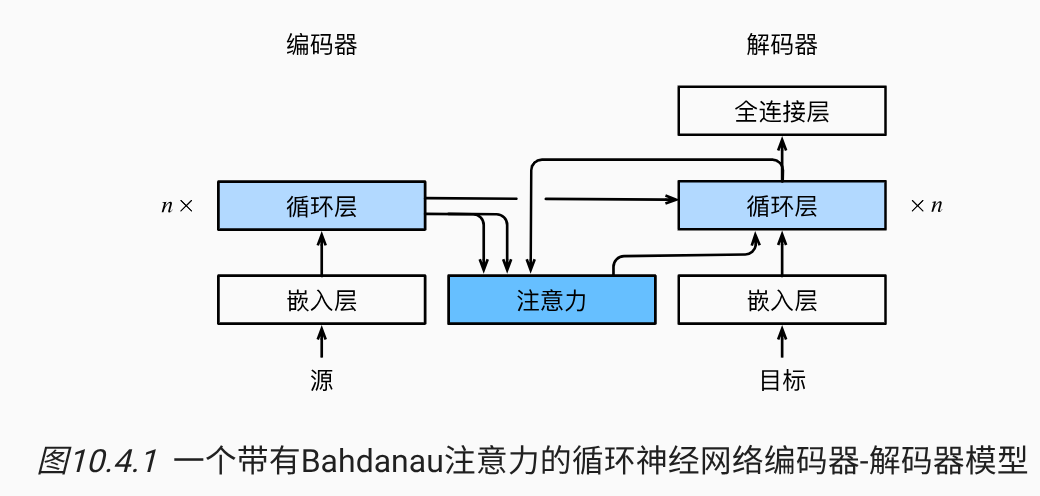

**思考: 注意力如何理解?**
我的理解: 首先需要注意注意力机制中的 `Q, K, V` 三个对象, 其中 `Q` 表示查询, 可以理解为输入, 我们想要的输出就是这一个查询对应的预测值, `K, V` 分别为键和键对应的值(这里可以理解为训练集中的样本以及标签), 利用公式: 
$$
\mathbf{O} = softmax(\alpha(\mathbf{Q}, \mathbf{K})) \mathbf{K}
$$
其中注意力权重其实是表示每一个 `K` 对于 `Q` 的影响大小, 对于传统的`RNN`等模型没有考虑注意力(其实应该有体现, 但是需要学习), 注意力机制有助于更有侧重点的学习模型(大概是这一个意思), 可以表示权重关系

## 定义注意力解码器

In [2]:
# 首先定义注意力解码器基本接口
#@save
class AttentionDecoder(d2l.Decoder):
    """带有注意力机制的解码器接口"""
    def __init__(self, **kwargs):
        super(AttentionDecoder, self).__init__(**kwargs)
    @property
    def attention_weights(self):
        raise NotImplementedError

下面实现 `Seq2SeqAttentionDecoder`类, 实现带有 `Banhanau`注意力的循环神经网络编码器, 首先初始化解码器的状态, 需要如下输入:
1. 编码器在所有时间步的最终层隐状态, 将作为注意力的键和值
2. 上一时间步的编码器全局隐状态, 将作为初始化解码器的隐状态
3. 编码器有效长度(排除在注意力池中的填充词元)

在每一个解码时间步骤中, 解码器上一个时间步的最终层隐状态将用作查询, 因此注意力输出和输入嵌入都联结为循环神经网络编码器的输入

In [3]:
class Seq2SeqAttentionDecoder(AttentionDecoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqAttentionDecoder, self).__init__(**kwargs)
        # 使用加性注意力, 其中参数分别为 Q,K,V 对应的特征数
        # 这里 Q,K,V都是隐状态, 所以特整数量都是 num_hiddens
        self.attention = mdl.AdditiveAttention(
            num_hiddens, num_hiddens, num_hiddens, dropout)
        # 嵌入层, 表示单个词元
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # 输入 (y_t', c_t') 拼接, 特征数相加
        self.rnn = nn.GRU(
            embed_size + num_hiddens, num_hiddens, num_layers,
            dropout=dropout)
        # 线性层, 结果为输出
        self.dense = nn.Linear(num_hiddens, vocab_size)
        
    def init_state(self, enc_outputs, enc_valid_lens, *args):
        # outputs的形状为(batch_size，num_steps，num_hiddens).
        # hidden_state的形状为(num_layers，batch_size，num_hiddens)
        outputs, hidden_state = enc_outputs
        return (outputs.permute(1, 0, 2), hidden_state, enc_valid_lens)

    def forward(self, X, state):
        # enc_outputs的形状为(batch_size,num_steps,num_hiddens).
        # hidden_state的形状为(num_layers,batch_size,
        # num_hiddens)
        # 最后一层隐状态集, 最后一个时间步隐状态, 输入有效长度(?)
        enc_outputs, hidden_state, enc_valid_lens = state
        # 输出X的形状为(num_steps,batch_size,embed_size)
        X = self.embedding(X).permute(1, 0, 2)
        outputs, self._attention_weights = [], []
        for x in X:
            # query的形状为(batch_size,1,num_hiddens)
            # 提取最后一层隐状态, 并且添加一个维度
            query = torch.unsqueeze(hidden_state[-1], dim=1)
            # context的形状为(batch_size,1,num_hiddens)
            context = self.attention(
                query, enc_outputs, enc_outputs, enc_valid_lens)
            # 在特征维度上连结
            x = torch.cat((context, torch.unsqueeze(x, dim=1)), dim=-1)
            # 将x变形为(1,batch_size,embed_size+num_hiddens)
            out, hidden_state = self.rnn(x.permute(1, 0, 2), hidden_state)
            outputs.append(out)
            self._attention_weights.append(self.attention.attention_weights)
        # 全连接层变换后，outputs的形状为
        # (num_steps,batch_size,vocab_size)
        outputs = self.dense(torch.cat(outputs, dim=0))
        # 每一步计算一次
        return outputs.permute(1, 0, 2), [enc_outputs, hidden_state,
                                          enc_valid_lens]

    @property
    def attention_weights(self):
        return self._attention_weights

In [4]:
# 注意力编码器测试 7 个时间步, 4 个序列
encoder = d2l.Seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16,
                             num_layers=2)
encoder.eval()
decoder = Seq2SeqAttentionDecoder(vocab_size=10, embed_size=8, num_hiddens=16,
                                  num_layers=2)
decoder.eval()
X = torch.zeros((4, 7), dtype=torch.long)  # (batch_size,num_steps)
state = decoder.init_state(encoder(X), None)
output, state = decoder(X, state)
output.shape, len(state), state[0].shape, len(state[1]), state[1][0].shape

(torch.Size([4, 7, 10]), 3, torch.Size([4, 7, 16]), 2, torch.Size([4, 16]))

## 训练
> 注意力机制需要消耗一定的算理, 所以收敛很慢

loss 0.020, 8231.7 tokens/sec on cpu


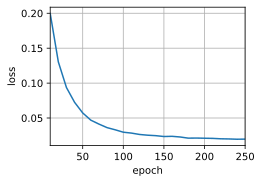

In [6]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 250, d2l.try_gpu()

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)
encoder = d2l.Seq2SeqEncoder(
    len(src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqAttentionDecoder(
    len(tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
net = mdl.EncoderDecoder(encoder, decoder)
mdl.train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

In [7]:
# 预测
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, dec_attention_weight_seq = d2l.predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device, True)
    print(f'{eng} => {translation}, ',
          f'bleu {d2l.bleu(translation, fra, k=2):.3f}')

go . => va !,  bleu 1.000
i lost . => j'ai perdu .,  bleu 1.000
he's calm . => je suis gros .,  bleu 0.000
i'm home . => je suis chez moi .,  bleu 1.000


In [8]:
attention_weights = torch.cat([step[0][0][0] for step in dec_attention_weight_seq], 0).reshape((
    1, 1, -1, num_steps))  # 注意力权重

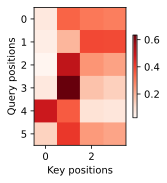

In [11]:
# 查看注意力权重
# 加上一个包含序列结束词元
d2l.show_heatmaps(
    attention_weights[:, :, :, :len(engs[-1].split()) + 1].cpu(),
    xlabel='Key positions', ylabel='Query positions')